Epoch 1/100
8/8 [==============================] - 6s 17ms/step - loss: 0.3468
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0700
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0627
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0461
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0447
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0425
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0410
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0405
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0395
Epoch 10/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0392
Epoch 11/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0386
Epoch 12/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0380
Epoch 13/100
8/8 [==============================]

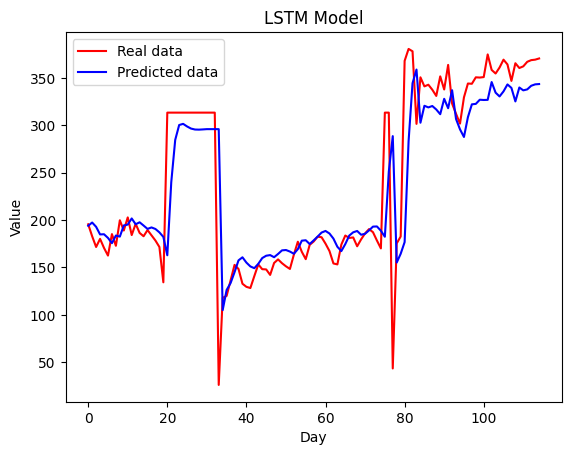

In [17]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 加载数据
data = pd.read_excel('./副本2022送电量.xlsx',sheet_name='Sheet2')
#根据时间排序
data = data.sort_values(by='date')
# 将date列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = data.loc[data['value'] != 0, 'value'].mean()
# 将0替换为去零后的均值
data['value'] = data['value'].replace(0, mean_value)
train_set = data.iloc[:250, 0:1].values
test_set = data.iloc[250:, 0:1].values

# 数据归一化
#目的是将数据缩放到一个特定的范围内，并且保持所有特征之间的比例不变，以便更好地将数据提供给机器学习算法进行分析和处理。
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)

# 创建训练集数据和标签
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 10
X_train, y_train = create_dataset(train_set_scaled, look_back)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

"""
这段代码创建了一个两层LSTM加一个全连接层(Dense)的深度神经网络模型。具体解释如下：
Sequential()：顺序模型是最常用的模型类型，允许用户按顺序将神经网络层添加到模型中。
LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))：LSTM层是一种特殊的循环神经网络(RNN)，在处理时间序列数据时表现优异。该层包含50个LSTM单元，return_sequences=True表示返回所有时间步长的输出，input_shape是输入数据的形状，这里是（时间步长，特征维数）。
LSTM(units=50)：第二个LSTM层，包含50个LSTM单元，默认return_sequences=False表示在最后一个时间步长返回输出。
Dense(units=1)：全连接(Dense)层，包含1个神经元，用于将LSTM层的输出映射为单个输出值。
compile(optimizer='adam', loss='mean_squared_error')：这里使用Adam优化器，并将均方误差作为损失函数。
因此，这个LSTM模型将输入的时间序列数据经过50个LSTM单元的处理，然后再经过另外50个LSTM单元的处理，最后通过全连接层得到一个预测结果。这个模型结构的每一层都使用了默认的激活函数，即LSTM层使用tanh函数，全连接层使用线性函数。
"""

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 进行预测
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 绘制预测结果
import matplotlib.pyplot as plt
plt.plot(test_set, color='red', label='Real data')
plt.plot(predicted, color='blue', label='Predicted data')
plt.title('LSTM Model')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()


加载数据并进行预处理，包括去除0值和数据归一化。
创建训练集数据和标签，并调整数据形状以适应LSTM模型输入。
创建LSTM模型，包括两个LSTM层和一个Dense层，并使用Adam优化器和均方误差作为损失函数进行编译。
对训练集进行训练，并进行预测。
对预测结果进行可视化。

4/4 [==============================] - 0s 9ms/step


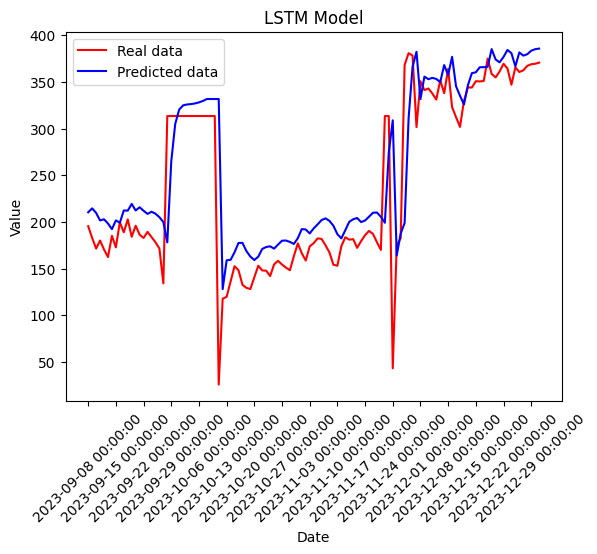

In [16]:
# 进行预测并绘图
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 取出测试集数据的日期
dates = list(data.index.values[-len(test_set):])

# 将预测值、实际值和日期存储在一个DataFrame中
results = pd.DataFrame({'date': dates, 'real': test_set.ravel(), 'predicted': predicted.ravel()})
results.set_index('date', inplace=True)

# 绘制预测结果
import matplotlib.pyplot as plt
plt.plot(results.index, results['real'], color='red', label='Real data')
plt.plot(results.index, results['predicted'], color='blue', label='Predicted data')
# 设置x轴上的日期标签
plt.xticks(results.index[::7], results.index[::7], rotation=45)

plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
